## HackerEarth Deep Learning Challenge Solution

#### Resnet18 Trnsfer Learning simple model with PyTorch

Image Augmentation is done to boost the dataset.

In [1]:
#!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia
!nvidia-smi

Tue Feb 25 09:05:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!cp 'drive/My Drive/DL_GALA/9d34462453e311ea.zip' .
!unzip 9d34462453e311ea.zip

Import all necessary libraries

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
import torchvision.models as models
from torch import optim
import torch.nn.functional as F

Plotting images and analysing them

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Configuration parameters

In [0]:
class Config():
    training_dir = "dataset/Train Images"
    testing_dir = "dataset/Test Images/"
    training_csv = "dataset/train.csv"
    testing_csv = "dataset/test.csv"
    train_batch_size = 32
    train_number_epochs = 100

Load the dataset csv files and then create dict for class files

In [0]:
import pandas as pd

train_df = pd.read_csv('dataset/train.csv')

test_df = pd.read_csv('dataset/test.csv')

classes = train_df.Class.unique()
label_to_int = {item:idx for idx, item in enumerate(classes)}
int_to_label = {idx:item for idx, item in enumerate(classes)}
label_to_int, int_to_label

Dataset loader, train loader returns image and label from csv

In [0]:
class GalaDataset(Dataset):
    """GalaDataset dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with images and classes.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        label = label_to_int[label]
        

        if self.transform:
            image = self.transform(image)

        return image, label

Augmentation of images and creating the Dataloader for PyTorch

In [0]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.01)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)


train_dataset = GalaDataset(csv_file =Config.training_csv, root_dir=Config.training_dir,
                                        transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    ImgAugTransform(),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

Visualize and analyse few images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2, 0, 0, 3, 2, 0, 2, 0])


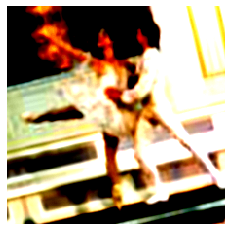

In [10]:
import os
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
print(example_batch[1])
imshow(example_batch[0][6])

Data distribution across classes

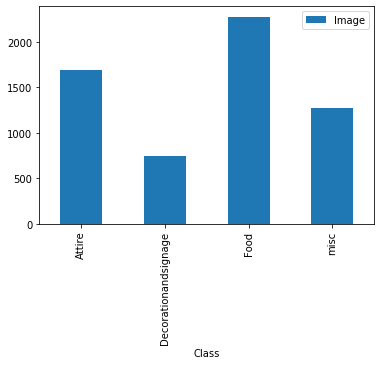

In [11]:
train_df.groupby('Class').count().plot.bar()

Set device for training and loading data

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model trainer code

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
    # dataiter = iter(vis_dataloader)


    # example_batch = next(dataiter)
# concatenated = torch.cat((exa

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataloader.__len__()
            epoch_acc = running_corrects.double() / dataloader.__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Create the simple model structure, optimiser.
The model architecture is simple and contains the pretrained model and a fully connected last layer.

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features


for layer in model_ft.parameters():
    layer.requires_grad = False
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Epoch 0/19
----------
train Loss: 7.9391 Acc: 4.8877
val Loss: 5.5405 Acc: 5.8610

Epoch 1/19
----------
train Loss: 6.7830 Acc: 5.4184
val Loss: 4.3514 Acc: 6.3583

Epoch 2/19
----------
train Loss: 5.7699 Acc: 5.7714
val Loss: 3.3579 Acc: 6.7420

Epoch 3/19
----------
train Loss: 5.3868 Acc: 5.9559
val Loss: 3.3990 Acc: 6.6832

Epoch 4/19
----------
train Loss: 5.1413 Acc: 6.0735
val Loss: 3.4659 Acc: 6.6684

Epoch 5/19
----------
train Loss: 4.5363 Acc: 6.3222
val Loss: 2.7822 Acc: 6.9799

Epoch 6/19
----------
train Loss: 4.1381 Acc: 6.5281
val Loss: 2.1072 Acc: 7.2701

Epoch 7/19
----------
train Loss: 2.9842 Acc: 6.8743
val Loss: 1.5402 Acc: 7.4960

Epoch 8/19
----------
train Loss: 2.6933 Acc: 7.0374
val Loss: 1.4495 Acc: 7.4947

Epoch 9/19
----------
train Loss: 2.4930 Acc: 7.1203
val Loss: 1.2815 Acc: 7.5842

Epoch 10/19
----------
train Loss: 2.2683 Acc: 7.1898
val Loss: 1.1041 Acc: 7.6471

Epoch 11/19
----------
train Loss: 2.2322 Acc: 7.1912
val Loss: 1.0708 Acc: 7.6471

E

Test Dataset loader

In [0]:
class GalaDatasetTest(Dataset):
    """GalaDataset dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with images and classes.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert('RGB')

        

        if self.transform:
            image = self.transform(image)

        return image, self.dataframe.iloc[idx, 0]

test_loader = GalaDatasetTest(csv_file =Config.testing_csv, root_dir=Config.testing_dir,
                                        transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # ImgAugTransform(),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

test_loader = DataLoader(test_loader,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)


Predict for all the data in the test csv with the trained model

In [55]:
def predict_test(model):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    res = []
    with torch.no_grad():
        for i, (inputs, row) in enumerate(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                
                res.append([row[j], int_to_label[preds.tolist()[j]]])
                
        
        return res

res = predict_test(model_ft)

<Figure size 432x288 with 0 Axes>

Predictions

In [60]:
pd.DataFrame(res, columns = ['Image', 'Class'])

,Image,Class
0,image7199.jpg,misc
1,image9867.jpg,misc
2,image8135.jpg,misc
3,image1822.jpg,Food
4,image6818.jpg,Attire
...,...,...
3214,image2633.jpg,Attire
3215,image10765.jpg,Food
3216,image3090.jpg,misc
3217,image10241.jpg,Attire


Original test csv

In [65]:
test_df

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg
...,...
3214,image4968.jpg
3215,image6673.jpg
3216,image3442.jpg
3217,image8178.jpg


Merge predictions and create the submission csv file.

In [0]:
test_df.merge(pd.DataFrame(res, columns = ['Image', 'Class']), on='Image').to_csv('submission.csv', index=None)